# Modelos Machine Learning

Una vez hecha la limpieza de datos vamos a pasar a crear los modelos para predecir los precios de airbnb según las caracteristicas de los alojamientos.

In [103]:
#Carga de Librerías

#Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#Librerias básicas
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

#Transformacion de los datos 
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#Metricas
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

#Grid search
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


#Modelos básicos
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

#Arboles y ensamblaje 
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor


pd.set_option('display.max_rows', 500) # para mostrar todas las filas
pd.set_option('display.max_columns', None) # para mostrar todas las columnas

In [104]:
#Carga de datos limpios
dfl = pd.read_csv('df_limpio.csv', delimiter=',').iloc[:, 1:]

In [105]:
dfl.head(3)

,host response time,host response rate,host verifications,latitude,longitude,property type,room type,bathrooms,bedrooms,beds,bed type,amenities,security deposit,cleaning fee,guests included,extra people,minimum nights,maximum nights,availability 365,number of reviews,cancellation policy,features,price,average review,final neighbourhood,years being host
0,within an hour,84.0,3,40.406953,-3.670894,Apartment,Private room,2.0,1.0,1.0,Real Bed,7,183.0,30.0,1,5,1,1125,240,171,flexible,3,28.0,20.142857,Retiro,2
1,within a few hours,100.0,3,40.425904,-3.681647,Apartment,Entire home/apt,1.0,0.0,1.0,Real Bed,13,100.0,30.0,1,0,2,1125,15,52,moderate,3,58.0,22.285714,Salamanca,2
2,within an hour,100.0,5,40.428352,-3.687155,Apartment,Entire home/apt,1.0,0.0,2.0,Real Bed,17,150.0,30.0,2,15,2,1125,292,36,flexible,4,70.0,20.571429,Salamanca,1


## Transformación de datos

### Variables categóricas

#### Categóricas ordinales, es decir, siguien un orden específico

En esta categoría encontramos *'host response time'* y *'cancellation policy'*

In [106]:
# Orden de las categorías
host_response_time_order = ['within an hour', 'within a few hours', 'within a day', 'a few days or more']
cancellation_policy_order = ['flexible', 'moderate', 'strict']
encoder = OrdinalEncoder(categories=[host_response_time_order, cancellation_policy_order])
dfl_catord = dfl.copy()
dfl_catord['host response time'] = dfl['host response time'].map({category: i for i, category in enumerate(host_response_time_order)})
dfl_catord['cancellation policy'] = dfl['cancellation policy'].map({category: i for i, category in enumerate(cancellation_policy_order)})
dfl_catord.head(2)

,host response time,host response rate,host verifications,latitude,longitude,property type,room type,bathrooms,bedrooms,beds,bed type,amenities,security deposit,cleaning fee,guests included,extra people,minimum nights,maximum nights,availability 365,number of reviews,cancellation policy,features,price,average review,final neighbourhood,years being host
0,0,84.0,3,40.406953,-3.670894,Apartment,Private room,2.0,1.0,1.0,Real Bed,7,183.0,30.0,1,5,1,1125,240,171,0,3,28.0,20.142857,Retiro,2
1,1,100.0,3,40.425904,-3.681647,Apartment,Entire home/apt,1.0,0.0,1.0,Real Bed,13,100.0,30.0,1,0,2,1125,15,52,1,3,58.0,22.285714,Salamanca,2


#### Categóricas que no siguien un orden específico

In [107]:
categoricas =['property type','room type', 'bed type', 'final neighbourhood'   
]
encoder = OneHotEncoder()
dfl_cat = encoder.fit_transform(dfl_catord[categoricas])
dfl_cat = pd.DataFrame(dfl_cat.toarray(), columns=encoder.get_feature_names_out(categoricas))
data_encoded = pd.concat([dfl_catord.drop(categoricas, axis=1), dfl_cat], axis=1)

In [108]:
data_encoded.head(2)

,host response time,host response rate,host verifications,latitude,longitude,bathrooms,bedrooms,beds,amenities,security deposit,cleaning fee,guests included,extra people,minimum nights,maximum nights,availability 365,number of reviews,cancellation policy,features,price,average review,years being host,property type_Apartment,property type_Bed & Breakfast,property type_Condominium,property type_House,property type_Loft,property type_Other,room type_Entire home/apt,room type_Private room,room type_Shared room,bed type_Pull-out Sofa,bed type_Real Bed,final neighbourhood_Arganzuela,final neighbourhood_Carabanchel,final neighbourhood_Centro,final neighbourhood_Chamartín,final neighbourhood_Chamberí,final neighbourhood_Ciudad Lineal,final neighbourhood_Latina,final neighbourhood_Moncloa - Aravaca,final neighbourhood_Puente de Vallecas,final neighbourhood_Retiro,final neighbourhood_Salamanca,final neighbourhood_Tetuán
0,0,84.0,3,40.406953,-3.670894,2.0,1.0,1.0,7,183.0,30.0,1,5,1,1125,240,171,0,3,28.0,20.142857,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1,100.0,3,40.425904,-3.681647,1.0,0.0,1.0,13,100.0,30.0,1,0,2,1125,15,52,1,3,58.0,22.285714,2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Separación rain y test 

In [109]:
X_train, X_test, y_train, y_test = train_test_split(data_encoded, data_encoded['price'], test_size=0.30, random_state=42)

In [110]:
X_train.drop(['price'], axis=1, inplace=True)
X_test.drop(['price'], axis=1, inplace=True)

In [111]:
X_train.head(2)

,host response time,host response rate,host verifications,latitude,longitude,bathrooms,bedrooms,beds,amenities,security deposit,cleaning fee,guests included,extra people,minimum nights,maximum nights,availability 365,number of reviews,cancellation policy,features,average review,years being host,property type_Apartment,property type_Bed & Breakfast,property type_Condominium,property type_House,property type_Loft,property type_Other,room type_Entire home/apt,room type_Private room,room type_Shared room,bed type_Pull-out Sofa,bed type_Real Bed,final neighbourhood_Arganzuela,final neighbourhood_Carabanchel,final neighbourhood_Centro,final neighbourhood_Chamartín,final neighbourhood_Chamberí,final neighbourhood_Ciudad Lineal,final neighbourhood_Latina,final neighbourhood_Moncloa - Aravaca,final neighbourhood_Puente de Vallecas,final neighbourhood_Retiro,final neighbourhood_Salamanca,final neighbourhood_Tetuán
114,0,100.0,6,40.403312,-3.692192,1.0,1.0,3.0,20,183.0,25.0,2,15,2,365,295,8,0,6,22.428571,2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5322,0,100.0,4,40.394676,-3.693656,2.0,1.0,2.0,15,100.0,30.0,1,25,2,20,362,0,0,3,21.257599,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [112]:
X_train.shape

(8547, 44)

## Modelos básicos

Para estos modelos necesitamos que las variables estén escaladas. 

#### Escalado de variables

In [113]:
scaler = StandardScaler()
model_scaled = scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

#### 1. Regresión linear

In [114]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred_lr = lr.predict(X_test_scaled)

# Calcular el error cuadrático medio
mse_lr = mean_squared_error(y_test, y_pred_lr)
print("Error cuadrático medio:",round(mse_lr,2))

#Calcular r^2
r2_lr = r2_score(y_test, y_pred_lr)
print('Coeficiente de determinación R^2:',round(r2_lr,2))

train_score_lr = lr.score(X_train_scaled, y_train)
print("Train score:", round(train_score_lr,2))

# Calcular el puntaje de prueba
test_score_lr = lr.score(X_test_scaled, y_test)
print("Test score:", round(test_score_lr,2))

Error cuadrático medio: 1877.23
Coeficiente de determinación R^2: 0.48
Train score: 0.47
Test score: 0.48


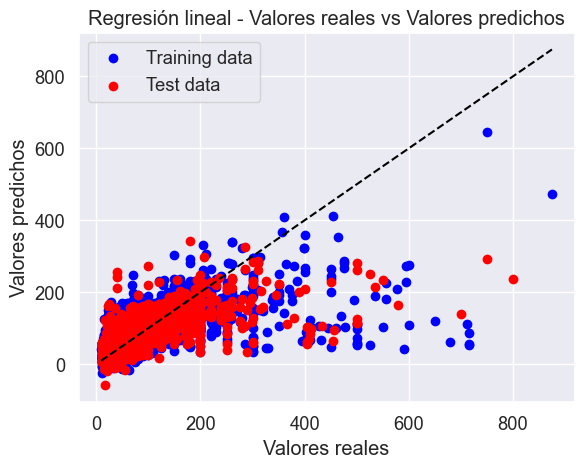

In [115]:
y_train_pred = lr.predict(X_train_scaled)
y_test_pred = lr.predict(X_test_scaled)

plt.scatter(y_train, y_train_pred, color='blue', label='Training data')
plt.scatter(y_test, y_test_pred, color='red', label='Test data')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='black', linestyle='--')
plt.xlabel('Valores reales')
plt.ylabel('Valores predichos')
plt.title('Regresión lineal - Valores reales vs Valores predichos')
plt.legend()
plt.show()

#### 2. Ridge Regression

In [116]:
ridge = Ridge(alpha=0.1) 
ridge.fit(X_train_scaled, y_train)
y_pred_ridge = ridge.predict(X_test_scaled)

# Calcular el error cuadrático medio
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
print("Error cuadrático medio:",round(mse_ridge,2))

#Calcular r^2
r2_ridge = r2_score(y_test, y_pred_ridge)
print('Coeficiente de determinación R^2:',round(r2_ridge,2))

train_score_ridge = ridge.score(X_train_scaled, y_train)
print("Train score:", round(train_score_ridge,2))

# Calcular el puntaje de prueba
test_score_ridge = ridge.score(X_test_scaled, y_test)
print("Test score:", round(test_score_ridge,2))

Error cuadrático medio: 1877.18
Coeficiente de determinación R^2: 0.48
Train score: 0.47
Test score: 0.48


In [117]:
parameters = {'alpha': [0.0001,0.001,0.01,0.1,10,100, 1000, 10000, 100000]}
ridge = Ridge()

# Gridsearch
grid_search = GridSearchCV(ridge, parameters)
grid_search.fit(X_train_scaled, y_train)

# Mejores parametros
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

Mejores hiperparámetros: {'alpha': 100}


In [118]:
ridge = Ridge(alpha=100) 
ridge.fit(X_train_scaled, y_train)
y_pred_ridge = ridge.predict(X_test_scaled)

# Calcular el error cuadrático medio
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
print("Error cuadrático medio:",round(mse_ridge,2))

#Calcular r^2
r2_ridge = r2_score(y_test, y_pred_ridge)
print('Coeficiente de determinación R^2:',round(r2_ridge,2))

train_score_ridge = ridge.score(X_train_scaled, y_train)
print("Train score:", round(train_score_ridge,2))

# Calcular el puntaje de prueba
test_score_ridge = ridge.score(X_test_scaled, y_test)
print("Test score:", round(test_score_ridge,2))

Error cuadrático medio: 1876.31
Coeficiente de determinación R^2: 0.48
Train score: 0.47
Test score: 0.48


#### 3. Lasso 

In [119]:
lasso = Lasso(alpha=0.1)
lasso.fit(X_train_scaled, y_train)
y_pred_lasso = lasso.predict(X_test_scaled)

# Calcular el error cuadrático medio
mse = mean_squared_error(y_test, y_pred_lasso)
print("Error cuadrático medio:",round(mse,2))

#Calcular r^2
r2 = r2_score(y_test, y_pred_lasso)
print('Coeficiente de determinación R^2:',round(r2,2))

train_score = lasso.score(X_train_scaled, y_train)
print("Train score:", round(train_score,2))

# Calcular el puntaje de prueba
test_score = lasso.score(X_test_scaled, y_test)
print("Test score:", round(test_score,2))

Error cuadrático medio: 1876.25
Coeficiente de determinación R^2: 0.48
Train score: 0.47
Test score: 0.48


In [120]:
parameters = {'alpha': [0.01, 0.1, 0.3,0.8, 1.0]} 

lasso = Lasso()

# Grid search
grid_search = GridSearchCV(lasso, parameters)
grid_search.fit(X_train_scaled, y_train)

# Mejores parametros
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

Mejores hiperparámetros: {'alpha': 0.3}


In [121]:
lasso = Lasso(alpha=0.3)  
lasso.fit(X_train_scaled, y_train)
y_pred_lasso = lasso.predict(X_test_scaled)

# Calcular el error cuadrático medio
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
print("Error cuadrático medio:",round(mse_lasso,2))

#Calcular r^2
r2_lasso = r2_score(y_test, y_pred_lasso)
print('Coeficiente de determinación R^2:',round(r2_lasso,2))

train_score_lasso = lasso.score(X_train_scaled, y_train)
print("Train score:", round(train_score_lasso,2))

# Calcular el puntaje de prueba
test_score_lasso = lasso.score(X_test_scaled, y_test)
print("Test score:", round(test_score_lasso,2))

Error cuadrático medio: 1877.86
Coeficiente de determinación R^2: 0.48
Train score: 0.47
Test score: 0.48


Tanto Lasso como Ridge no han añadido valor a los resultados ya reflejados por el modelo de regresión lineal. es por eso que a continuación probaremos con otros modelos más complejos con los que se espera obtener mejores resultados.

## Árboles y ensamblaje

Los modelos de árboles no requieren normalización de los datos. Lo que vamos a realizar es: 
1. Ejecutar el modelo sin ningún parámetro.
2. Realizar una validación cruzada con varios parámetros para averiguar cuales son los mejores.
3. Volver a ejecutar el modelo con los parámetros que maximizan el rendimiento.

#### Decision Tree Regressor

In [22]:
tree = DecisionTreeRegressor()

# Entrenar el modelo con los datos de entrenamiento
tree.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred_tree = tree.predict(X_test)

# Calcular el error cuadrático medio
mse_tree = mean_squared_error(y_test, y_pred_tree)
print("Error cuadrático medio:",round(mse_tree,2))

#Calcular r^2
r2_tree = r2_score(y_test, y_pred_tree)
print('Coeficiente de determinación R^2:',round(r2_tree,2))

train_score_tree = tree.score(X_train, y_train)
print("Train score:", round(train_score_tree,2))

# Calcular el puntaje de prueba
test_score_tree = tree.score(X_test, y_test)
print("Test score:", round(test_score_tree,2))


Error cuadrático medio: 2455.09
Coeficiente de determinación R^2: 0.32
Train score: 1.0
Test score: 0.32


In [34]:
grid_tree_model = DecisionTreeRegressor(random_state=42)

param_grid_tree = {
    'max_depth': [None,3,5,7, 10, 13,15],  # Valores para probar la profundidad máxima del árbol
    'min_samples_split': [2,5,8,10],  # Valores para probar el número mínimo de muestras requeridas para dividir un nodo interno
    # Agrega otros parámetros que desees ajustar
}
# Grid search
grid_search_tree = GridSearchCV(estimator=grid_tree_model, param_grid=param_grid_tree, cv=5, scoring='neg_mean_squared_error')
grid_search_tree.fit(X_train, y_train)

# Mejores parametros
best_params_tree = grid_search_tree.best_params_
best_model_tree = grid_search_tree.best_estimator_

best_params_tree

{'max_depth': 5, 'min_samples_split': 2}

In [122]:
tree = DecisionTreeRegressor(max_depth=5, min_samples_split =2)

# Entrenar el modelo con los datos de entrenamiento
tree.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred_tree = tree.predict(X_test)

# Calcular el error cuadrático medio
mse_tree = mean_squared_error(y_test, y_pred_tree)
print("Error cuadrático medio:",round(mse_tree,2))

#Calcular r^2
r2_tree = r2_score(y_test, y_pred_tree)
print('Coeficiente de determinación R^2:',round(r2_tree,2))

train_score_tree = tree.score(X_train, y_train)
print("Train score:", round(train_score_tree,2))

# Calcular el puntaje de prueba
test_score_tree = tree.score(X_test, y_test)
print("Test score:", round(test_score_tree,2))


Error cuadrático medio: 1751.37
Coeficiente de determinación R^2: 0.52
Train score: 0.65
Test score: 0.52


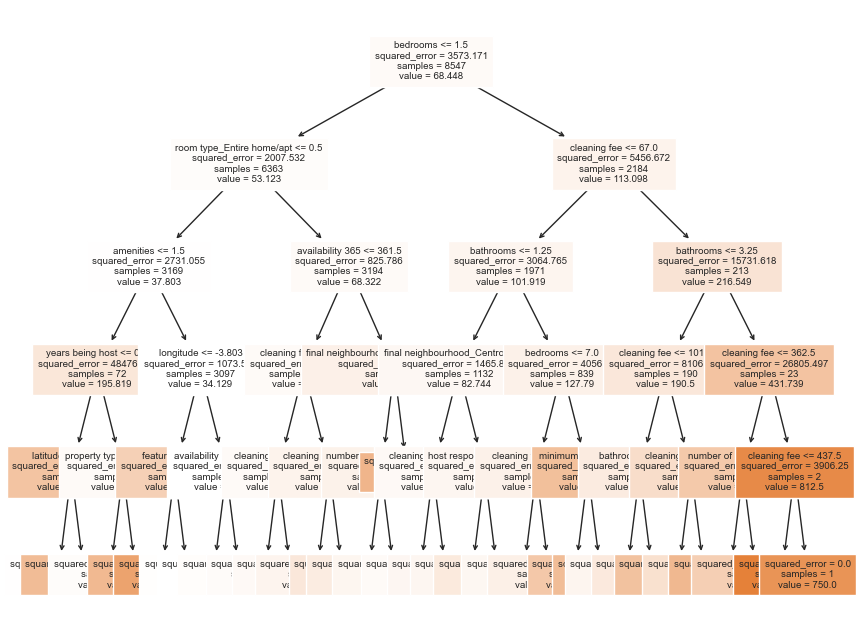

In [28]:
plt.figure(figsize=(10, 8))
plot_tree(tree, filled=True, feature_names=X_train.columns,fontsize=7)
plt.show()

#### Random Forest Regressor 

In [123]:
rf_model = RandomForestRegressor()

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Calcular el error cuadrático medio
mse_rf = mean_squared_error(y_test, y_pred_rf)
print("Error cuadrático medio:",round(mse_rf,2))

#Calcular r^2
r2_rf = r2_score(y_test, y_pred_rf)
print('Coeficiente de determinación R^2:',round(r2_rf,2))

train_score_rf = rf_model.score(X_train, y_train)
print("Train score:", round(train_score_rf,2))

# Calcular el puntaje de prueba
test_score_rf = rf_model.score(X_test, y_test)
print("Test score:", round(test_score_rf,2))

Error cuadrático medio: 1251.21
Coeficiente de determinación R^2: 0.65
Train score: 0.95
Test score: 0.65


In [39]:
grid_rf_model = RandomForestRegressor(random_state=42)

param_grid_rf = {
    'n_estimators': [100, 200, 300],  # Valores para probar el número de árboles en el bosque
    'max_depth': [None, 3, 5, 7, 10, 13, 15],  # Valores para probar la profundidad máxima de los árboles
    'min_samples_split': [2, 5, 8, 10],  # Valores para probar el número mínimo de muestras requeridas para dividir un nodo interno
}

# Grid search
grid_search_rf = GridSearchCV(estimator=grid_rf_model, param_grid=param_grid_rf, cv=5, scoring='neg_mean_squared_error')
grid_search_rf.fit(X_train, y_train)

# Mejores parametros
best_params_rf = grid_search_rf.best_params_
best_model_rf = grid_search_rf.best_estimator_

best_params_rf

{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}

In [44]:
rf_model = RandomForestRegressor(max_depth = None, min_samples_split =2, n_estimators= 100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Calcular el error cuadrático medio
mse_rf = mean_squared_error(y_test, y_pred_rf)
print("Error cuadrático medio:",round(mse_rf,2))

#Calcular r^2
r2_rf = r2_score(y_test, y_pred_rf)
print('Coeficiente de determinación R^2:',round(r2_rf,2))

train_score_rf = rf_model.score(X_train, y_train)
print("Train score:", round(train_score_rf,2))

# Calcular el puntaje de prueba
test_score_rf = rf_model.score(X_test, y_test)
print("Test score:", round(test_score_rf,2))

Error cuadrático medio: 1259.08
Coeficiente de determinación R^2: 0.65
Train score: 0.95
Test score: 0.65


#### Gradient Boosting Regressor

In [131]:
gb_model = GradientBoostingRegressor()

# Entrenar el modelo
gb_model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred_gb = gb_model.predict(X_test)

# Calcular el error cuadrático medio
mse_gb = mean_squared_error(y_test, y_pred_gb)
print("Error cuadrático medio:", round(mse_gb, 2))

# Calcular el coeficiente de determinación R^2
r2_gb = r2_score(y_test, y_pred_gb)
print('Coeficiente de determinación R^2:', round(r2_gb, 2))

# Calcular el puntaje de entrenamiento
train_score_gb = gb_model.score(X_train, y_train)
print("Train score:", round(train_score_gb, 2))

# Calcular el puntaje de prueba
test_score_gb = gb_model.score(X_test, y_test)
print("Test score:", round(test_score_gb, 2))

Error cuadrático medio: 1306.98
Coeficiente de determinación R^2: 0.64
Train score: 0.73
Test score: 0.64


In [ ]:
grid_gb_model = GradientBoostingRegressor(random_state=42)

param_grid_gb = {
    'n_estimators': [100, 200, 300],  # Valores para probar el número de árboles en el bosque
    'learning_rate': [0.1, 0.01, 0.001],  # Valores para probar la tasa de aprendizaje
    'max_depth': [3, 5, 7],  # Valores para probar la profundidad máxima de los árboles
    'min_samples_split': [2, 5, 8, 10]  # Valores para probar el número mínimo de muestras requeridas para dividir un nodo interno

}

# Grid search
grid_search_gb = GridSearchCV(estimator=grid_gb_model, param_grid=param_grid_gb, cv=5, scoring='neg_mean_squared_error')
grid_search_gb.fit(X_train, y_train)

# Mejores parametros
best_params_gb = grid_search_gb.best_params_
best_model_gb = grid_search_gb.best_estimator_

best_params_gb

#La solucion ha sido: {'learning_rate': 0.1,  'max_depth': 5,  'min_samples_split': 10,  'n_estimators': 100}

In [50]:
gb_model = GradientBoostingRegressor(learning_rate= 0.1, max_depth= 5, min_samples_split =10, n_estimators= 100)

# Entrenar el modelo
gb_model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred_gb = gb_model.predict(X_test)

# Calcular el error cuadrático medio
mse_gb = mean_squared_error(y_test, y_pred_gb)
print("Error cuadrático medio:", round(mse_gb, 2))

# Calcular el coeficiente de determinación R^2
r2_gb = r2_score(y_test, y_pred_gb)
print('Coeficiente de determinación R^2:', round(r2_gb, 2))

# Calcular el puntaje de entrenamiento
train_score_gb = gb_model.score(X_train, y_train)
print("Train score:", round(train_score_gb, 2))

# Calcular el puntaje de prueba
test_score_gb = gb_model.score(X_test, y_test)
print("Test score:", round(test_score_gb, 2))

Error cuadrático medio: 1163.66
Coeficiente de determinación R^2: 0.68
Train score: 0.86
Test score: 0.68


En general vemos, que en los tres modelos de árboles realizados, cuando añadimos los valores obtenidos de la validación cruzada el tran score y test score aumentan, mientras que el error cuadrático medio disminuye. 

## Comparación de modelos

#### Predicciones según el modelo 

In [129]:
data = {
    'Precio': y_test,
    'Precio lr': np.round(y_pred_lr,2),    
    'Precio tree': np.round(y_pred_tree,2), 
    'Precio rf': np.round(y_pred_rf,2),
    'Precio gb': np.round(y_pred_gb,2)
}

df = pd.DataFrame(data, index=X_test.index)
dfplot = df.head(10)
dfplot

,Precio,Precio lr,Precio tree,Precio rf,Precio gb
2919,60.0,114.88,132.58,109.64,147.91
4561,39.0,11.10,32.37,33.63,33.20
5206,80.0,50.97,58.86,62.05,66.57
3101,25.0,43.74,32.37,34.64,37.45
8203,44.0,71.84,71.21,83.07,69.64
1355,20.0,5.10,32.37,20.92,14.37
1369,150.0,139.88,132.58,136.86,159.87
6870,25.0,-1.97,32.37,29.63,27.68
2968,50.0,50.06,58.86,54.14,45.14
6066,26.0,49.49,47.84,49.20,54.90


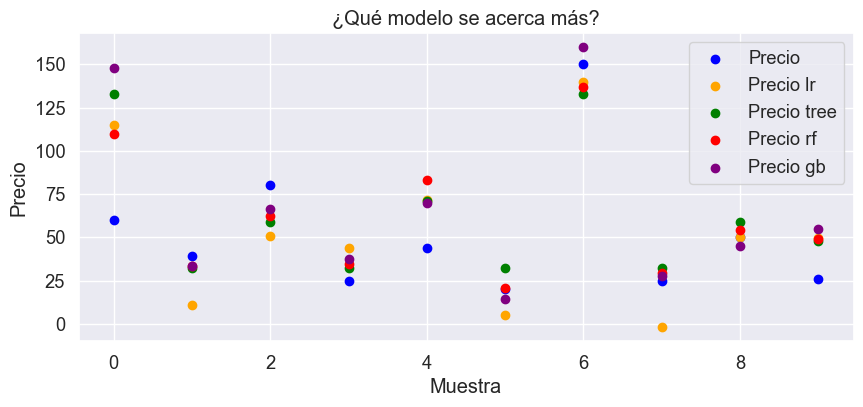

In [130]:
colores = ['blue', 'orange', 'green', 'red', 'purple']
fig, ax = plt.subplots(figsize=(10, 4))
for i, columna in enumerate(dfplot.columns):
    valores = dfplot[columna].values
    ax.scatter(range(len(valores)), valores, c=colores[i], label=columna)
ax.legend()
ax.set_xlabel('Muestra')
ax.set_ylabel('Precio')
plt.title('¿Qué modelo se acerca más?')
plt.show()

En este gráfico podemos ver en azul el precio real de los airbnb y en el resto de colores los precios predichos por cada modelo. En general el modelo que más se acerca a predecir los valores reales es el Gradient boos, siendo el valor más cercano en 4 de las 10 muestras escogidas.  

#### Comparación de métricas

In [126]:
modelos = ['Regresión Lineal','Árbol de decision', 'Random Forest', 'GradientBoost' ]
MSE = [round(mse_lr, 2),round(mse_tree, 2),round(mse_rf, 2),round(mse_gb, 2)]
r_cuadrado = [round(r2_lr, 2),round(r2_tree, 2),round(r2_rf, 2),round(r2_gb, 2)]
train_score = [round(train_score_lr, 2),round(train_score_tree, 2),round(train_score_rf, 2),round(train_score_gb, 2)]
test_score= [round(test_score_lr, 2),round(test_score_tree, 2),round(test_score_rf, 2),round(test_score_gb, 2)]

comparativa = pd.DataFrame(
    {'Modelos':modelos, 
    'MSE':MSE,
    'R^2':r_cuadrado,
    'Train score':train_score,
    'Test score':test_score
    })

comparativa

,Modelos,MSE,R^2,Train score,Test score
0,Regresión Lineal,1877.23,0.48,0.47,0.48
1,Arbol de decision,1751.37,0.52,0.65,0.52
2,Random Forest,1251.21,0.65,0.95,0.65
3,GradientBoost,1163.66,0.68,0.86,0.68


En cuanto a las métricas obtenidas de los modelos, podemos observar que, el mejor modelo para predecir los precios de airbnb según las características de los apartamentos es Gradient Boost, puesto que, pese a tener un train score levemente más bajo que random forest, en el resto de las métricas obtiene mejores valores, teniendo también el error cuadrático medio más bajo. 